# Intro
<font color=blue> In this notebook, I have introduced an special image denoising problem which can be called sequence image denoising. In this problem, we have number of different noisy image from one original image. The task is to reach the original image using its set of noisy images. The method was based on LSTM convolutional neural networks. **It is a variation of long short term memory networks, where input transformations and recurrent transformations are both convolutional.**
Before starting to read the method, I ask you to consider some points related to this implementation:<br></font>
1. The model was designed by keras api and in python language.
2. The model is a simple model which can be test by cpu.
3. I used generators to train my model.
4. The input in this model is a sequence of 5 images, each of which is from same patch with different Gaussian noise. The main patch (and obviously the sequence) has 128x128 dimension. The images were in grayscale color space.
5. The original data which the model was trained and validate by, was so large. Hence it wasn't rational to upload the data. But I tried to show some example images and also describe the structure of saved data.

# Importing packages and modules

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow.keras.callbacks as tkc
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras import models
import h5py
from scipy.ndimage import gaussian_filter as gf

# Create and manage dataset
For designing Denoising model, we need image dataset. For this purpose, I used **[Caltech 101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)**.<br>
I chose some images from this dataset randomly with one condition: _The shape of the image must be bigger than 128x128_ , so I could extract a random patch from this image. After that, I generate 5 images from this patch by adding different Gaussian noise to it.<br>
After that, I categorized chosen images into three categories:<br>
1-Train <br>
2- Validation <br>
3- Test <br>
I managed the dataset in hdf5 format(Creating three different datasets in one file).<br>
## structure of dataset
Here is the method of creating dataset: <br>
I saved original image(patch) as **Label**, and noisy images sequence as **Inputs**. I repeated this procedure for each image.<br>
**Note** <br>
- **For producing Gaussian noise, we need to choose sigma (or variance) for Gaussian distribution. For more flexibility of the model, I chose this noise randomly for each image of sequence between [.1,.2] interval. Of course this interval can be changed, based on the problem.**  <br> 
- **Both original images and noisy images were scaled between [0,1].** <br>
I saved the result in an HDF file named 'Data.hdf', which is loaded in the below cell. You can also see the internal structure of the file.

In [4]:
f=h5py.File('Data_Seq.hdf','r')
f.visit(lambda x: print (x))

Test
Test/Inputs
Test/Labels
Train
Train/Inputs
Train/Labels
Val
Val/Inputs
Val/Labels


Here is the dimension of train data:

In [3]:
f['/Train/Inputs'].shape

(1020, 5, 128, 128, 1)

As you can see, we have 980 sequence of noisy images, where each sequence consists of 5 noisy image.

# Number of data
Here is the number of data in each category.

In [4]:
print ('Number of train data : {}'.format (len(f['/Train/Inputs'])))
print ('Number of validation data : {}'.format (len(f['/Val/Inputs'])))
print ('Number of test data : {}'.format (len(f['/Test/Inputs'])))

Number of train data : 1020
Number of validation data : 160
Number of test data : 70


# Some samples of dataset
In the below cells, you can see some examples of training data and their labels respectively. Note that all the images are 128x128 and in each row you can see a sample sequence.

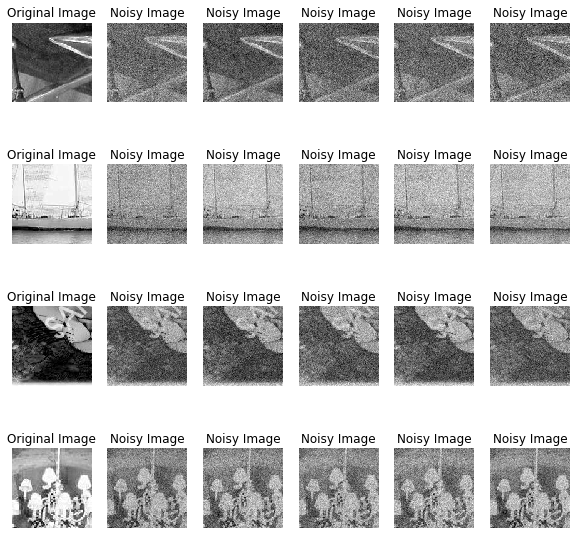

In [5]:
fig , ax = plt.subplots(4,6,figsize=(10,10))
for i in range(4):
    c=np.random.randint(len(f['/Train/Inputs']))
    ax[i,0].imshow(f['/Train/Labels'][c,:,:,0],cmap='gray'),ax[i,0].axis('off') , ax[i,0].set_title('Original Image')
    for j in range(5):
        ax[i,j+1].imshow(f['/Train/Inputs'][c,j,:,:,0],cmap='gray'),ax[i,j+1].axis('off') , ax[i,j+1].set_title('Noisy Image')
    
    

Note that the each image in sequence has a unique noise. To show this I subtracted two images of one sequence. You can see the results below.

(<matplotlib.image.AxesImage at 0x241f18bca08>,
 (-0.5, 127.5, 127.5, -0.5),
 Text(0.5, 1.0, 'Difference of first and second noisy image'))

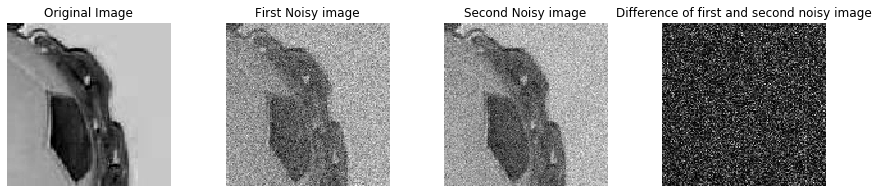

In [6]:
c=np.random.randint(len(f['/Train/Inputs']))
fig , ax = plt.subplots(1,4,figsize=(15,3))
ax[0].imshow(f['/Train/Labels'][c,:,:,0],cmap='gray'),ax[0].axis('off') , ax[0].set_title('Original Image')
ax[1].imshow(f['/Train/Inputs'][c,0,:,:,0],cmap='gray'),ax[1].axis('off') , ax[1].set_title('First Noisy image')
ax[2].imshow(f['/Train/Inputs'][c,1,:,:,0],cmap='gray'),ax[2].axis('off') , ax[2].set_title('Second Noisy image')
ax[3].imshow(abs(f['/Train/Inputs'][c,0,:,:,0]-f['/Train/Inputs'][c,1,:,:,0]),cmap='gray'),ax[3].axis('off') , ax[3].set_title('Difference of first and second noisy image')

# Set parameters
Now, let's turn to more machine learning task!<br>
First I set some parameters for furthur usage.

In [7]:
batch_size     = 16
nb_ephochs     = 10
input_shape    = (5,128,128,1)

# Network structure
For designing Denoising network, I chose LSTM convolutional neural network. I chose a simple model which comprised of 2 LSTMconv layers. Here are some important notes in designing this network: <br>
**Notes**<br>
- I had to choose smaller value for each batch, because context based networks take more memory.
- Unfortunately I didn't have a powerful processor or gpu. So I had to design simple model which could be run on cpu fast.
- Size of filters are all set to 3. This number inferred by trial and error. However, the filter size of 3 is a common choice in designing CNNs.<br>

In [8]:
model = Sequential()
model.add(layers.ConvLSTM2D(5,kernel_size=3,input_shape=input_shape,return_sequences=True,padding='same'))
#model.add(layers.ConvLSTM2D(5,kernel_size=3,activation='relu', recurrent_activation='relu',
        #                    return_sequences=True,padding='same'))
model.add(layers.ConvLSTM2D(1,kernel_size=3,activation='relu',
                            return_sequences=False,padding='same'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 5, 128, 128, 5)    1100      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 128, 128, 1)       220       
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


# Optimzer, Loss and Callbacks
I used adam optimizer with learning rate of 0.01 which was decreased on loss function plateau. I used mse as a loss function because the problem is to Denoising and we wanted to make same input and output. For accuracy metric, I chose mae, because the value of pixels are between [0,1], and mae From a perspective shows the precent of error in each pixel (I know it is a weak reason, however I think mae is more informative than mse for accuracy!) <br>
To control the training procedure, I defined some callbacks: <br>
1. Model check point: to save the best model during training process.
2. Reduce on plateau: to reduce the learning rate when the loss function get stuck.

In [9]:
opt=optimizers.Adam(learning_rate=0.01)
mc=tkc.ModelCheckpoint('model_seq.hdf5',save_best_only=True)
rop=tkc.ReduceLROnPlateau(factor=0.5,patience=3,min_lr=0.00001,min_delta=0.01,verbose=1)

# Data generator
Because of my weak system and low RAM and big size of data, I decided to use generator techniques to train my network. For this purpose I had to design a generator function which each time bring a batch of data to memory for train. The function below does the explained task. The function takes an HDF group and batch size as inputs and yields batches of training data and labels in a decent manner. <br>

In [10]:
def data_prep(f,batch_size):
    while True:
        for i in range(0,f['Inputs'].shape[0],batch_size):
            p=np.random.permutation(f['Inputs'].shape[0])
            selected_p=p[:batch_size]
            selected_p.sort()
            yield f['Inputs'][selected_p[:batch_size]],f['Labels'][selected_p[:batch_size]]

Next I defined two generator functions to use in fit_generator model method. One function belongs to train and the other belongs to validation data.

In [11]:
train_generator=data_prep(f['/Train'],batch_size)
val_generator=data_prep(f['/Val'],batch_size)

# Compile and train network

In [12]:
model.compile(optimizer=opt,loss='mse',metrics=['mae'])
num_train_data=f['/Train/Inputs'].shape[0]
model.fit_generator(train_generator,
                    steps_per_epoch=np.floor(num_train_data/batch_size),
                    epochs=nb_ephochs,
                    verbose=1,validation_data=val_generator,validation_steps=1,callbacks=[mc,rop])


Epoch 1/10
63/63 [==============================] - 498s 8s/step - loss: 0.0628 - mae: 0.1748 - val_loss: 0.0168 - val_mae: 0.0985
Epoch 2/10
63/63 [==============================] - 534s 8s/step - loss: 0.0200 - mae: 0.1057 - val_loss: 0.0143 - val_mae: 0.0957
Epoch 3/10
63/63 [==============================] - 484s 8s/step - loss: 0.0201 - mae: 0.1084 - val_loss: 0.0355 - val_mae: 0.1283
Epoch 4/10
62/63 [============================>.] - ETA: 7s - loss: 0.0183 - mae: 0.1043 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
63/63 [==============================] - 494s 8s/step - loss: 0.0182 - mae: 0.1042 - val_loss: 0.0241 - val_mae: 0.1131
Epoch 5/10
63/63 [==============================] - 481s 8s/step - loss: 0.0169 - mae: 0.1000 - val_loss: 0.0176 - val_mae: 0.1041
Epoch 6/10
63/63 [==============================] - 518s 8s/step - loss: 0.0151 - mae: 0.0941 - val_loss: 0.0117 - val_mae: 0.0858
Epoch 7/10
62/63 [============================>.] - ETA:

# Evaluate the results
Now it's time to check and evaluate the output of model. In the below cell, I tested a sequence of noisy image.<br>
**You can test your own images with little changes on below code! (Just change the file path to your desired image)** <br>
****Note**** <br>
**The train data was generated by Gaussian noise with variance between [.1,.2]. Although you can add Gaussian noise with any variance to your desired image, the best result will be produce on the noise with same variance.**<br>
For testing the model, I have upload a trained model based on full data (which I couldn't upload it). So first I have to load that model.

In [4]:
model=models.load_model('model_seq.hdf5')

(<matplotlib.image.AxesImage at 0x2418208c448>,
 (-0.5, 127.5, 127.5, -0.5),
 Text(0.5, 1.0, 'CNN_model_result'))

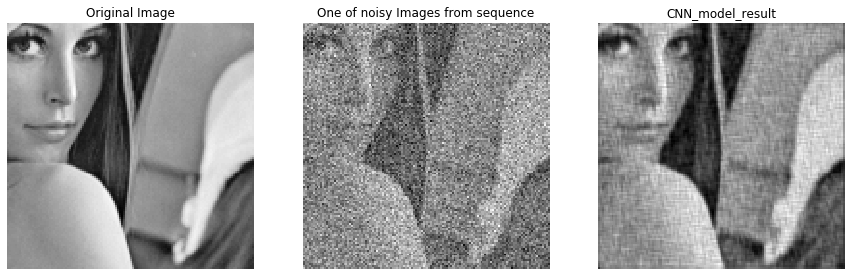

In [28]:
Original_image=plt.imread('test.jpg')

# Convert RGB image to grayscale image
Original_image=np.mean(Original_image,axis=2)
x_start=np.random.randint(0,Original_image.shape[0]-128)
y_start=np.random.randint(0,Original_image.shape[1]-128)
patch=Original_image[x_start:x_start+128,y_start:y_start+128]
#patch=patch/255

image_seq=np.zeros(shape=(5,128,128))
for j in range(5):
    sigma=np.random.uniform(.1,.2)
    noise=np.random.normal(scale=sigma,size=(128,128))
    noisy_data=patch/255+noise
    noisy_data=(noisy_data-np.min(noisy_data))/(np.max(noisy_data)-np.min(noisy_data))
    image_seq[j,:,:]=noisy_data
image_seq=np.expand_dims(image_seq,axis=3)   
image_seq=np.expand_dims(image_seq,axis=0)

CNN_result=model.predict(image_seq)
#Gaussian_filter_result = gf(sample[0,:,:,0], sigma=1)

fig, ax = plt.subplots(1,3,figsize=(15,35))
ax[0].imshow(patch,cmap='gray'), ax[0].axis('off') , ax[0].set_title('Original Image')
ax[1].imshow(image_seq[0,0,:,:,0],cmap='gray'), ax[1].axis('off') , ax[1].set_title('One of noisy Images from sequence')
ax[2].imshow(CNN_result[0,:,:,0],cmap='gray'), ax[2].axis('off') , ax[2].set_title('CNN_model_result')
#ax[1,1].imshow(Gaussian_filter_result,cmap='gray'), ax[1,1].axis('off') , ax[1,1].set_title('Gaussian filter_result')

Not too bad for a simple model with just 2 layers! We can improve the performance by both adding more data and adding more layers to network.

## What about when we don't have sequence of an image!
let's take a look at situation where we have just one noisy image and want to apply our sequence based model on it. For this purpose, we feed the single image as a sequence to network, just to watch what happend.

(<matplotlib.image.AxesImage at 0x241825c5608>,
 (-0.5, 127.5, 127.5, -0.5),
 Text(0.5, 1.0, 'CNN_model_result'))

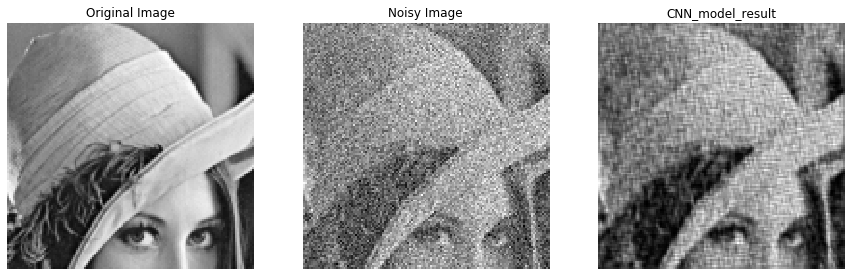

In [32]:
Original_image=plt.imread('test.jpg')

# Convert RGB image to grayscale image
Original_image=np.mean(Original_image,axis=2)
x_start=np.random.randint(0,Original_image.shape[0]-128)
y_start=np.random.randint(0,Original_image.shape[1]-128)
patch=Original_image[x_start:x_start+128,y_start:y_start+128]
#patch=patch/255

image_seq=np.zeros(shape=(5,128,128))

# bring noise generating procedure out of the loop, hence we have same noise for all sequence.
sigma=np.random.uniform(.1,.2)
noise=np.random.normal(scale=sigma,size=(128,128))

for j in range(5):
    noisy_data=patch/255+noise
    noisy_data=(noisy_data-np.min(noisy_data))/(np.max(noisy_data)-np.min(noisy_data))
    image_seq[j,:,:]=noisy_data
image_seq=np.expand_dims(image_seq,axis=3)   
image_seq=np.expand_dims(image_seq,axis=0)

CNN_result=model.predict(image_seq)
#Gaussian_filter_result = gf(sample[0,:,:,0], sigma=1)

fig, ax = plt.subplots(1,3,figsize=(15,35))
ax[0].imshow(patch,cmap='gray'), ax[0].axis('off') , ax[0].set_title('Original Image')
ax[1].imshow(image_seq[0,0,:,:,0],cmap='gray'), ax[1].axis('off') , ax[1].set_title('Noisy Image')
ax[2].imshow(CNN_result[0,:,:,0],cmap='gray'), ax[2].axis('off') , ax[2].set_title('CNN_model_result')
#ax[1,1].imshow(Gaussian_filter_result,cmap='gray'), ax[1,1].axis('off') , ax[1,1].set_title('Gaussian filter_result')

Obviously not so good! but its acceptible!